In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import SpectralEmbedding, LocallyLinearEmbedding, Isomap, TSNE
import umap
import GPy
import seaborn as sns
from scipy.sparse.csgraph import shortest_path
from scipy.sparse import csr_matrix
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

import imp

from ikd import utils, core, evaluate, datasets
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)

<module 'ikd.datasets' from '/storage/scratch1/1/cli726/ikd/ikd/ikd/datasets.py'>

In [2]:
digits = load_digits()
print(digits['data'])
print(digits.target)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
[0 1 2 ... 8 9 8]


In [4]:
def visualize(z_pred, method):
    for i in range(10):
        idx = digits.target == i
        plt.plot(z_pred[idx, 0], z_pred[idx, 1], '.', label=f'{i}')
    plt.legend()
    plt.title(f'{method}')

In [5]:
d_latent = 2
x = digits['data']

0.6032482203652121

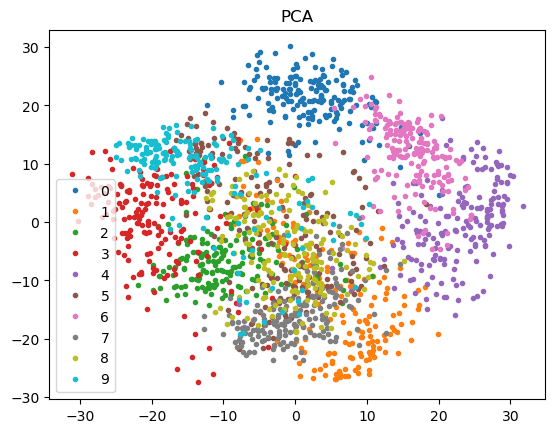

In [5]:
z_pca = PCA(n_components=d_latent).fit_transform(x)
visualize(z_pca, 'PCA')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_pca, digits.target, cv=5)
scores.mean()

0.7507180439492417

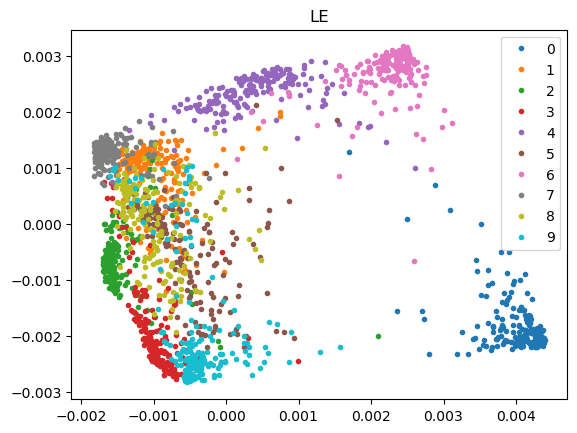

In [22]:
z_le = SpectralEmbedding(n_components=d_latent).fit_transform(x)
visualize(z_le, 'LE')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_le, digits.target, cv=5)
scores.mean()

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


0.9749705973382854

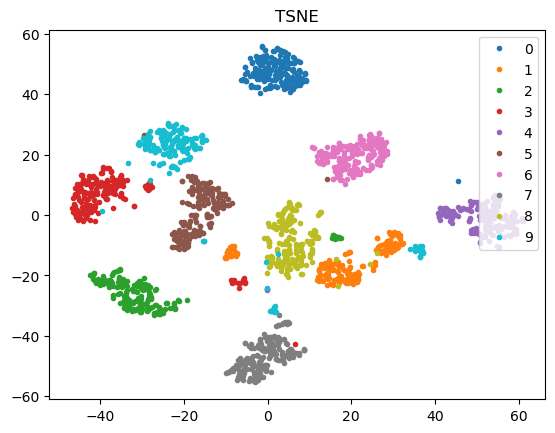

In [9]:
z_tsne = TSNE(n_components=d_latent, init='pca', learning_rate='auto', random_state=42).fit_transform(x)
visualize(z_tsne, 'TSNE')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_tsne, digits.target, cv=5)
scores.mean()

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


0.7868786753327144

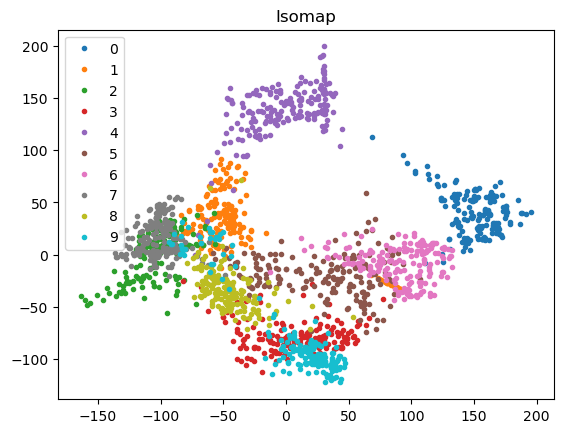

In [18]:
z_isomap = Isomap(n_components=d_latent, n_neighbors=5).fit_transform(x)
visualize(z_isomap, 'Isomap')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_isomap, digits.target, cv=5)
scores.mean()

0.9755292479108636

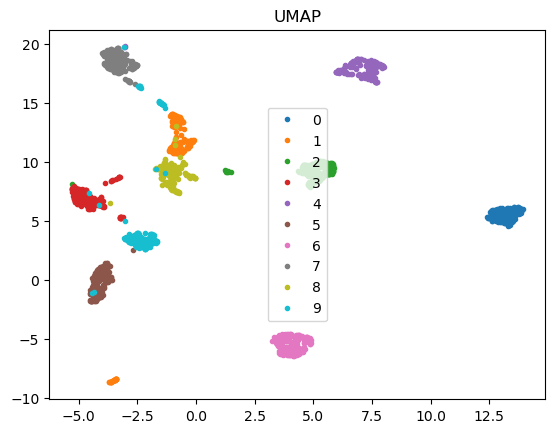

In [11]:
z_umap = umap.UMAP(n_components=d_latent, random_state=42).fit_transform(x)
visualize(z_umap, 'UMAP')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_umap, digits.target, cv=5)
scores.mean()

Too many remaining indices, use nearest neighbors to find all cliques for every points
Clique threshold: 0.6, number of cliques: 232


0.5704302073661405

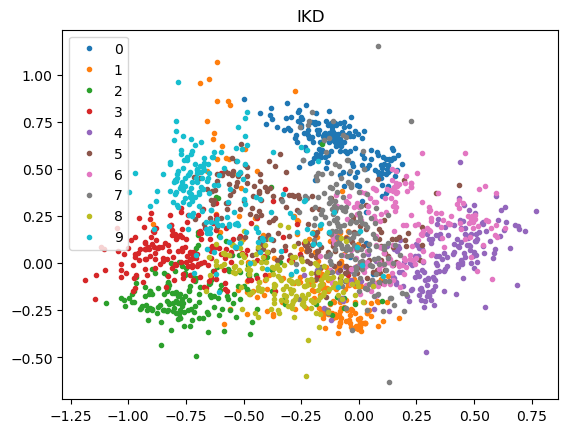

In [14]:
z_ikd = core.ikd_blockwise(x, d_latent=d_latent, clique_th=0.6, max_n_cliques=2)
visualize(z_ikd, 'IKD')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_ikd, digits.target, cv=5)
scores.mean()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   7.726302e+05           nan 
    04s44  0012   3.001751e+05   2.572039e+06 
    14s23  0039   2.603039e+05   6.062784e+06 
    41s32  0114   2.529726e+05   2.919536e+05 
 01m56s88  0324   2.521721e+05   7.404183e+04 
 05m28s95  0909   2.519403e+05   1.471947e+04 
 06m02s43  1002   2.519249e+05   2.134095e+02 
Runtime:  06m02s43
Optimization status: Maximum number of f evaluations reached



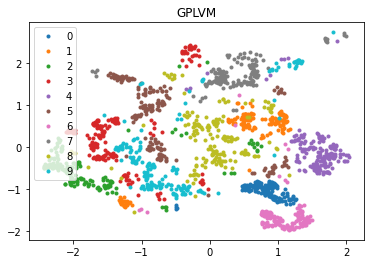

In [25]:
m_gplvm = GPy.models.GPLVM(x, d_latent, kernel=GPy.kern.RBF(d_latent, variance=1, lengthscale=1))
m_gplvm.likelihood.variance = 1.
m_gplvm.optimize(max_iters=1e3, messages=1)
visualize(m_gplvm.X.values, 'GPLVM')

如果已经知道距离了，那么直接取平方再取相反数，然后直接 IKD？

！！！ 本质上是更复杂的 GP 过程，生成协方差矩阵的核更复杂了

0.7701872485298671

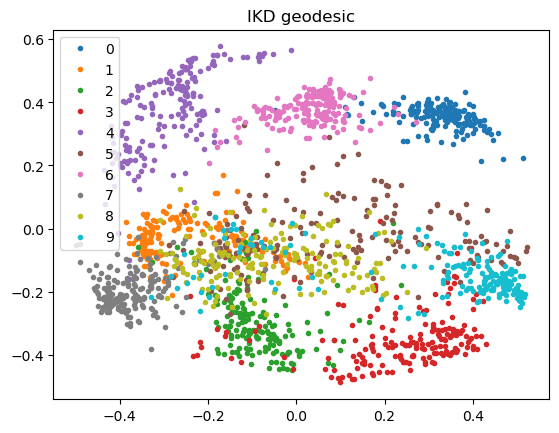

In [33]:
z_ikd = core.ikd_geodesic(x, d_latent, ref_point='center', clique_th=0.5)
visualize(z_ikd, 'IKD geodesic')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_ikd, digits.target, cv=5)
scores.mean()

0.8758991024450633

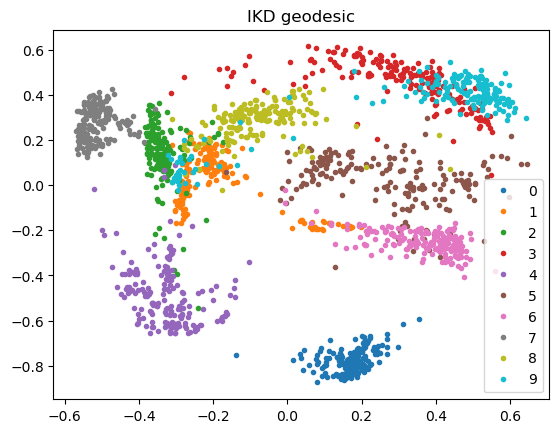

In [28]:
z_ikd = core.ikd_geodesic(x, d_latent, ref_point='center', n_neighbors=7)
visualize(z_ikd, 'IKD geodesic')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_ikd, digits.target, cv=5)
scores.mean()

## DNA

In [18]:
URL = "https://raw.githubusercontent.com/sods/ods/master/datasets/guo_qpcr.csv"

df = pd.read_csv(URL, index_col=0)
print("Data shape: {}\n{}\n".format(df.shape, "-" * 21))
print("Data labels: {}\n{}\n".format(df.index.unique().tolist(), "-" * 86))
print("Show a small subset of the data:")
df.head()

Data shape: (437, 48)
---------------------

Data labels: ['1', '2', '4', '8', '16', '32 TE', '32 ICM', '64 PE', '64 TE', '64 EPI']
--------------------------------------------------------------------------------------

Show a small subset of the data:


,Actb,Ahcy,Aqp3,Atp12a,Bmp4,Cdx2,Creb312,Cebpa,Dab2,DppaI,...,Sox2,Sall4,Sox17,Snail,Sox13,Tcfap2a,Tcfap2c,Tcf23,Utf1,Tspan8
1,0.541050,-1.203007,1.030746,1.064808,0.494782,-0.167143,-1.369092,1.083061,0.668057,-1.553758,...,-1.351757,-1.793476,0.783185,-1.408063,-0.031991,-0.351257,-1.078982,0.942981,1.348892,-1.051999
1,0.680832,-1.355306,2.456375,1.234350,0.645494,1.003868,-1.207595,1.208023,0.800388,-1.435306,...,-1.363533,-1.782172,1.532477,-1.361172,-0.501715,1.082362,-0.930112,1.064399,1.469397,-0.996275
1,1.056038,-1.280447,2.046133,1.439795,0.828121,0.983404,-1.460032,1.359447,0.530701,-1.340283,...,-1.296802,-1.567402,3.194157,-1.301777,-0.445219,0.031284,-1.005767,1.211529,1.615421,-0.651393
1,0.732331,-1.326911,2.464234,1.244323,0.654359,0.947023,-1.265609,1.215373,0.765212,-1.431401,...,-1.684100,-1.915556,2.962515,-1.349710,1.875957,1.699892,-1.059458,1.071541,1.476485,-0.699586
1,0.629333,-1.244308,1.316815,1.304162,0.707552,1.429070,-0.895578,-0.007785,0.644606,-1.381937,...,-1.304653,-1.761825,1.265379,-1.320533,-0.609864,0.413826,-0.888624,1.114394,1.519017,-0.798985


In [19]:
x = df.values
z = df.index.values

In [20]:
def visualize(z_pred, method):
    for i in np.unique(z):
        idx = z == i
        plt.plot(z_pred[idx, 0], z_pred[idx, 1], '.', label=f'{i}')
    plt.legend()
    plt.title(f'{method}')

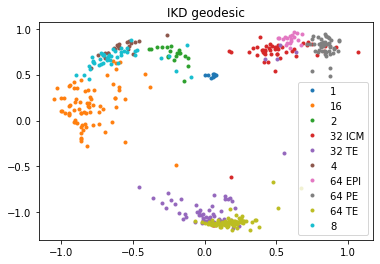

In [27]:
corr_samp = np.corrcoef(x)
corr_samp_th = corr_samp.copy()
corr_samp_th[corr_samp_th <= corr_samp.mean()] = 1

d = shortest_path(-np.log(corr_samp_th), directed=False)
corr_geodesic = np.exp(-d)

z_ikd = core.ikd(corr_geodesic, 2, ref_point='center')
visualize(z_ikd, 'IKD geodesic')

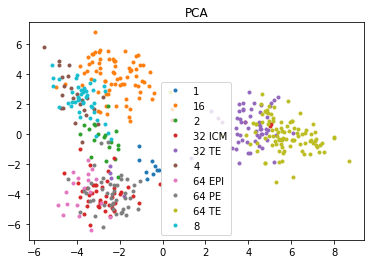

In [105]:
visualize(PCA(n_components=d_latent).fit_transform(x), 'PCA')

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:324: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


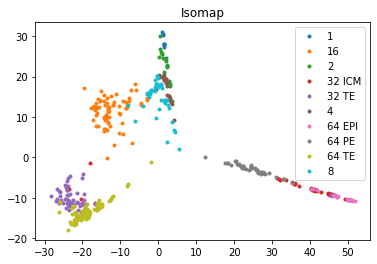

In [106]:
visualize(Isomap(n_components=d_latent).fit_transform(x), 'Isomap')

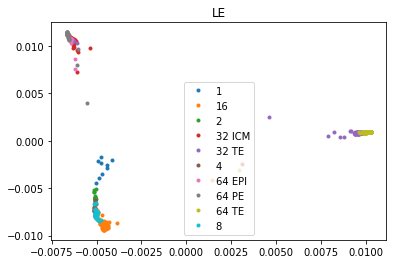

In [119]:
visualize(SpectralEmbedding(n_components=d_latent).fit_transform(x), 'LE')

Too many remaining indices, use nearest neighbors to find all cliques for every points
Clique threshold: 0.3, number of cliques: 178


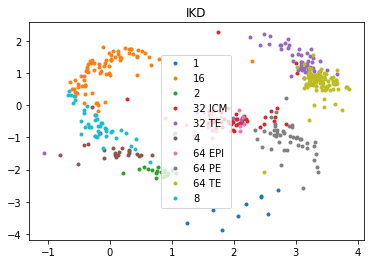

In [117]:
visualize(core.ikd_blockwise(x, d_latent=d_latent), 'IKD')

## VAE

In [5]:
import os

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [24]:
assert pyro.__version__.startswith('1.8.2')
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [25]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [63]:
dataset = TensorDataset(torch.from_numpy(x).to(torch.float32), torch.from_numpy(digits.target))
train_loader = DataLoader(dataset, batch_size=1797)

In [64]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 64)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

In [65]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(64, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 64)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [66]:
# define the model p(x|z)p(z)
def model(self, x):
    # register PyTorch module `decoder` with Pyro
    pyro.module("decoder", self.decoder)
    with pyro.plate("data", x.shape[0]):
        # setup hyperparameters for prior p(z)
        z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
        z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
        # sample from prior (value will be sampled by guide when computing the ELBO)
        z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
        # decode the latent code z
        loc_img = self.decoder(z)
        # score against actual images
        pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 64))

In [67]:
# define the guide (i.e. variational distribution) q(z|x)
def guide(self, x):
    # register PyTorch module `encoder` with Pyro
    pyro.module("encoder", self.encoder)
    with pyro.plate("data", x.shape[0]):
        # use the encoder to get the parameters used to define q(z|x)
        z_loc, z_scale = self.encoder(x)
        # sample the latent code z
        pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

In [68]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=2, hidden_dim=32, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 64))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [69]:
vae = VAE()

In [70]:
optimizer = Adam({"lr": 1.0e-3})

In [71]:
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [72]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [73]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [74]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False

# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 100
TEST_FREQUENCY = 5

In [75]:
train_loader, test_loader = train_loader, train_loader

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 90.8600
[epoch 000] average test loss: 62.4022
[epoch 001]  average training loss: 63.4560
[epoch 002]  average training loss: 48.2977
[epoch 003]  average training loss: 36.8276
[epoch 004]  average training loss: 27.8236
[epoch 005]  average training loss: 19.0636
[epoch 005] average test loss: 11.3302
[epoch 006]  average training loss: 11.3294
[epoch 007]  average training loss: 3.7575
[epoch 008]  average training loss: -3.6308
[epoch 009]  average training loss: -11.4018
[epoch 010]  average training loss: -18.6155
[epoch 010] average test loss: -26.2379
[epoch 011]  average training loss: -26.4257
[epoch 012]  average training loss: -34.0799
[epoch 013]  average training loss: -42.0090
[epoch 014]  average training loss: -50.5686
[epoch 015]  average training loss: -58.9726
[epoch 015] average test loss: -67.8955
[epoch 016]  average training loss: -68.1938
[epoch 017]  average training loss: -77.7065
[epoch 018]  average training loss: -88.23

In [76]:
with torch.no_grad():
    x, y = next(iter(train_loader))
    z_loc, z_scale = vae.encoder(x)

In [81]:
z = z_loc.detach().cpu().numpy()
y = y.detach().cpu().numpy()

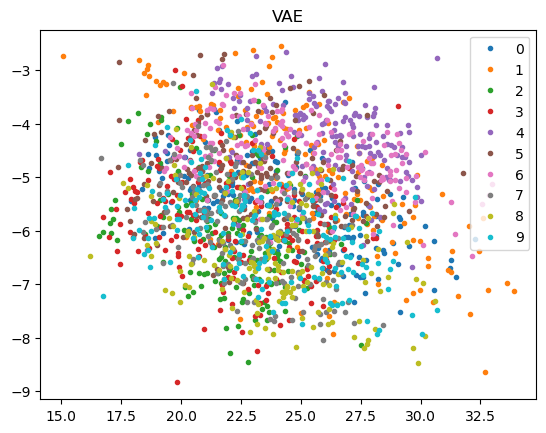

In [82]:
for i in range(10):
    idx = y == i
    plt.plot(z[idx, 0], z[idx, 1], '.', label=f'{i}')
    plt.legend()
    plt.title(f'VAE')